In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mp_pose = mp.solutions.pose
 
pose_image = mp_pose.Pose(static_image_mode=True, 
                          min_detection_confidence=0.5)
 
pose_video = mp_pose.Pose(static_image_mode=False, 
                          min_detection_confidence=0.7,
                          min_tracking_confidence=0.7)
 
mp_drawing = mp.solutions.drawing_utils

pose = mp_pose.Pose()

In [3]:
def detectPose(image_pose, pose, draw=False):
    original_image = image_pose.copy()
    image_in_RGB = cv2.cvtColor(image_pose, cv2.COLOR_BGR2RGB)
    resultant = pose.process(image_in_RGB)
    if resultant.pose_landmarks and draw:    
        mp_drawing.draw_landmarks(image=original_image, 
                                  landmark_list=resultant.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                               thickness=2, circle_radius=2),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
                                                                               thickness=2, circle_radius=2))
        mp_drawing.plot_landmarks(resultant.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
            
    return original_image, resultant


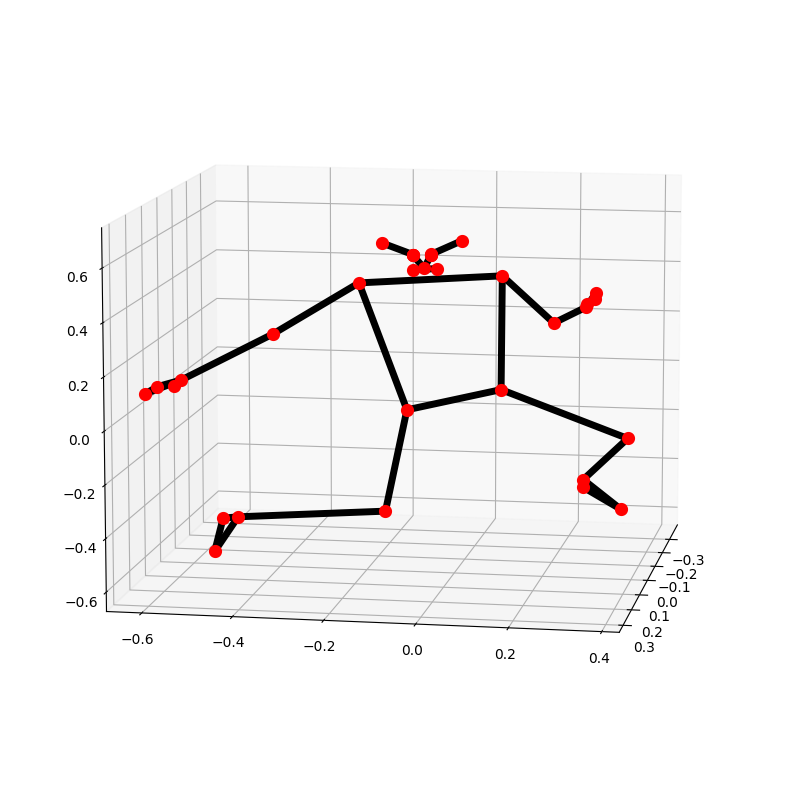

In [4]:
# PREPARING IMAGE
image = cv2.imread("test_slika2.jpg")
slika, res = detectPose(image, pose, True)
slika = cv2.cvtColor(slika, cv2.COLOR_BGR2RGB)


In [5]:
# PREPARING DATA - DICTIONARY WITH POINTS ON ALL AXIS

points = []
for data_point in res.pose_landmarks.landmark:
    points.append({
                    'X': data_point.x,
                    'Y': data_point.y,
                    'Z': data_point.z,
                    'Visibility': data_point.visibility})

spineTopX1 = points[11]["X"]
spineTopY1 = points[11]["Y"]
spineTopZ1 = points[11]["Z"]

spineTopX2 = points[12]["X"]
spineTopY2 = points[12]["Y"]
spineTopZ2 = points[12]["Z"]

spineBotX1 = points[23]["X"]
spineBotY1 = points[23]["Y"]
spineBotZ1 = points[23]["Z"]

spineBotX2 = points[24]["X"]
spineBotY2 = points[24]["Y"]
spineBotZ2 = points[24]["Z"]

vec1 = np.array([spineTopX1, spineTopY1, spineTopZ1])
vec2 = np.array([spineTopX2, spineTopY2, spineTopZ2])

vec3 = np.array([spineBotX1, spineBotY1, spineBotZ1])
vec4 = np.array([spineBotX2, spineBotY2, spineBotZ2])

spineTop = (vec1 + vec2) / 2
spineBot = (vec3 + vec4) / 2


In [6]:
for d in res.pose_landmarks.landmark[10:25]:
    print(d)

x: 0.4909469485282898
y: 0.2707013785839081
z: -0.5198958516120911
visibility: 1.0

x: 0.5543641448020935
y: 0.33834725618362427
z: 0.07328977435827255
visibility: 0.9999977350234985

x: 0.4093383848667145
y: 0.318247526884079
z: -0.29712381958961487
visibility: 0.9999994039535522

x: 0.6264790296554565
y: 0.42300906777381897
z: -0.004623843356966972
visibility: 0.9625880122184753

x: 0.3082546591758728
y: 0.40712904930114746
z: -0.3475814163684845
visibility: 0.9989398121833801

x: 0.7016602158546448
y: 0.3428834080696106
z: -0.40158239006996155
visibility: 0.9949813485145569

x: 0.18228282034397125
y: 0.4750039875507355
z: -0.5060068368911743
visibility: 0.997930645942688

x: 0.7190749645233154
y: 0.3249596953392029
z: -0.45640555024147034
visibility: 0.9886758327484131

x: 0.14432886242866516
y: 0.48611748218536377
z: -0.5393815040588379
visibility: 0.9935516119003296

x: 0.7114763259887695
y: 0.3139292597770691
z: -0.4766165614128113
visibility: 0.9896687865257263

x: 0.14402100443